Analysis of Plasmodium rebalancing in run10_11. Based on the experience from run9, primer concentrations were set as 80x P1/20x P2. Here, we incorporated the following variables:
- two feed experiments with infection rate estimated as 60% (f15) and 94% (f16)
- two to three sampling points during high (day 1, blood stage parasites still present) and low (days 8-14, oocysts/sporozoites only left) expected infection intensities - 16 mosquito individuals per sampling point
- two rounds of DNA extraction from the same individuals: e1 - non-destructive, e2 - grinding with beads
- two annealing/extension temperatures for PCR1: 51C and 55C - the latter presumably increasing annealing for AT-rich primers
- two cycling conditions: standard (used for previous runs) and subcycling (used in plasmodium production pipeline) 

Results:
- plasmodium read counts are somewhat correlated with the day post infection: max at day 1, lower at subsequent days
- there is a "background" level of ~10s reads detected in most uninfected samples. Almost none of infected samples have no reads
- although we expect the number of uninfected samples to correlate with infection rate, the proportion of samples with "background" number of reads is similar between feeds
- plasmodium read counts are affected by extraction - extraction 1 works better than extraction 2
- mosquito read counts are marginally lower with subcycling
- two factors affect P1/P2 read balance: extraction and cycling. Extraction 1 is about 10x more even than extraction 2. For cycling, difference in ratios is 2x. Equal number of reads is reached for combination of extraction 1 and subcycling.
- P1/P2 ratio in run9 was about 0.05 (pool 9, 80x P1/20x P2). Here, similar rate observed in extraction 2, but in extraction 1 it is significantly higher - 0.5 for standard cycling, 1 for subcycling
- subcycling heavily affects mosquito data filtering and also decreases the input read counts
- temperature did not have a significant effect
- infection statuses were estimated based on static thresholds. It works better for even ratios. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
READS = '../../../data/phylo_ampl_dada2/run10_11/dada2/output/stats.tsv'
HAPS = '../../../data/phylo_ampl_dada2/run10_11/dada2/output/haplotypes.tsv'

## Data prep

In [3]:
reads_init = pd.read_csv(READS, sep='\t')
reads_init.sample()

,s_Sample,target,input,filtered,denoisedF,denoisedR,merged,nonchim,final
30004,e2_f15_1d5_51c,56,41,40,40,40,40,40,40


In [4]:
# mean read counts across mosquito targets
mean_mosq = reads_init[~reads_init.target.str.startswith('P')].groupby('s_Sample').mean().reset_index()
mean_mosq['target'] = 'M_avg'
mean_mosq.sample()

,s_Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,final,target
125,e1_f15_1d8_51s,16.548387,16.112903,16.112903,16.112903,14.693548,14.693548,12.967742,M_avg


In [5]:
# mean read counts across mosquito targets
sum_mosq = reads_init[~reads_init.target.str.startswith('P')].groupby('s_Sample').sum().reset_index()
sum_mosq['target'] = 'M_sum'
sum_mosq.sample()

,s_Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,final,target
534,e2_f15_8d5_55c,10536,10269,10267,10269,10093,10093,10093,M_sum


In [6]:
# subset to plasmodium targets only
display(reads_init.shape)
reads = reads_init[reads_init.target.str.startswith('P')]
display(reads.shape)

(45568, 9)

(1424, 9)

In [7]:
# add averaged mosquito targets
display(reads.shape)
reads = pd.concat([reads, mean_mosq, sum_mosq], sort=True)
display(reads.shape)

(1424, 9)

(2848, 9)

In [8]:
# logscale input and output reads for plotting
reads['log_input'] = np.log10(reads['input'].replace(0,0.1)).fillna(-1)
reads['log_final'] = np.log10(reads['final'].replace(0,0.1)).fillna(-1)

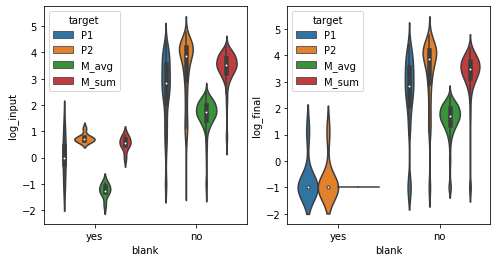

In [9]:
# read counts in blanks
reads['blank'] = 'no'
reads.loc[reads.s_Sample.str.contains('blank'), 'blank'] = 'yes'

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for ax, col in zip(axs.flatten(),
                   ['log_input','log_final']):
    sns.violinplot(data=reads,
                   x='blank', 
                   y=col,
                   hue='target',
                   ax=ax);
# low read counts as expected, mostly removed by filtering

In [10]:
# discard blanks
reads = reads[reads['blank'] == 'no']
reads.shape

(2816, 12)

In [11]:
# parse sequence names
def parse_sequence_names(reads):
    p = reads.s_Sample.str.split('_', expand=True)
    reads['extraction'] = p[0]
    reads['feed'] = p[1]
    # parse day and specimen
    di = p[2].str.split('d', expand=True)
    reads['day'] = di[0]
    reads['specimen'] = p[1] + '_' + p[2]
    # handle uninfected
    u = reads['day'].str.startswith('un')
    reads.loc[u, 'day'] = 'un'
    # handle day sorting
    sdd = reads.day.str.len() == 1
    reads.loc[sdd, 'day'] = '0' + reads.loc[sdd, 'day']
    # sampling points - combination of feed and day
    reads['sampling_point'] = reads.feed + '_' + reads.day
    reads['sampling_point'] = reads['sampling_point'].replace({'f15_13':'f15_13-14','f15_14':'f15_13-14'})
    # parse temp and cycling
    reads['extension_temp'] = p[3].str.slice(stop=-1) + 'C'
    reads['cycling'] = p[3].str.get(-1).replace({'s':'subcycling','c':'standard'})
    
    return reads
reads = parse_sequence_names(reads)
reads.sample()

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target,log_input,log_final,blank,extraction,feed,day,specimen,sampling_point,extension_temp,cycling
422,3449.0,3459.0,3459.0,3313.0,3541.0,3323.0,3323.0,e2_f15_14d8_55c,M_sum,3.549126,3.520221,no,e2,f15,14,f15_14d8,f15_13-14,55C,standard


In [12]:
reads.day.unique()

array(['13', '14', '01', '08', 'un', '09'], dtype=object)

## Overall plasmodium read counts

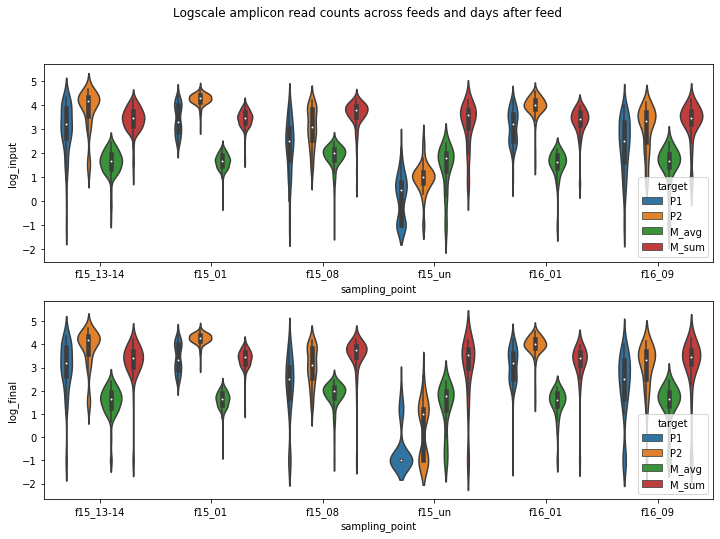

In [13]:
# total number of reads per day
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
for ax, col in zip(axs.flatten(),
                   ['log_input','log_final']):
    sns.violinplot(data=reads, 
                   x="sampling_point", 
                   y=col, 
                   hue="target", 
                   ax=ax);
fig.suptitle('Logscale amplicon read counts across feeds and days after feed');
# same as input reads

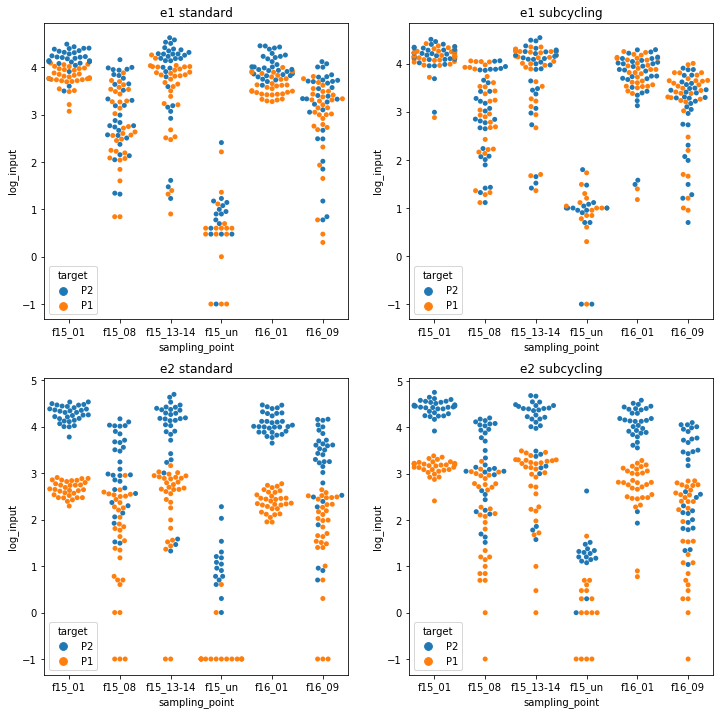

In [14]:
# same, with details on extraction and cycling
import itertools
fig, axs = plt.subplots(2,2, figsize=(12, 12))

i = 0

for extraction, cycling in itertools.product(['e1','e2'],
                                   ['standard','subcycling']):
    ax = axs.flatten()[i]
    d = reads[reads.target.str.startswith('P') 
              & (reads.extraction == extraction)
              & (reads.cycling == cycling)] \
            .sort_values('sampling_point')
    sns.swarmplot(data=d,
                  x='sampling_point',
                  y='log_input',
                  hue='target',
                  ax=ax)
    ax.set_title(extraction + ' ' + cycling)
    i += 1

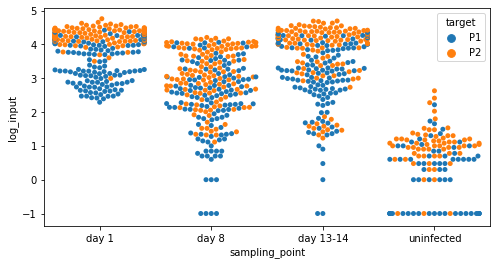

In [15]:
# same, highlighting difference in primer yields and with human-readable captions
k = reads[reads.target.str.startswith('P') 
                         & reads.sampling_point.str.startswith('f15')].sort_values('sampling_point')
k.sampling_point.replace({'f15_01':'day 1', 
                          'f15_08':'day 8', 
                          'f15_13-14':'day 13-14',
                          'f15_un':'uninfected'}, inplace=True)

fig, ax = plt.subplots(figsize=(8, 4))
sns.swarmplot(data=k, 
               x="sampling_point", 
               y="log_input",
               hue="target", 
#                color=sns.color_palette()[i], 
               ax=ax)
plt.show()

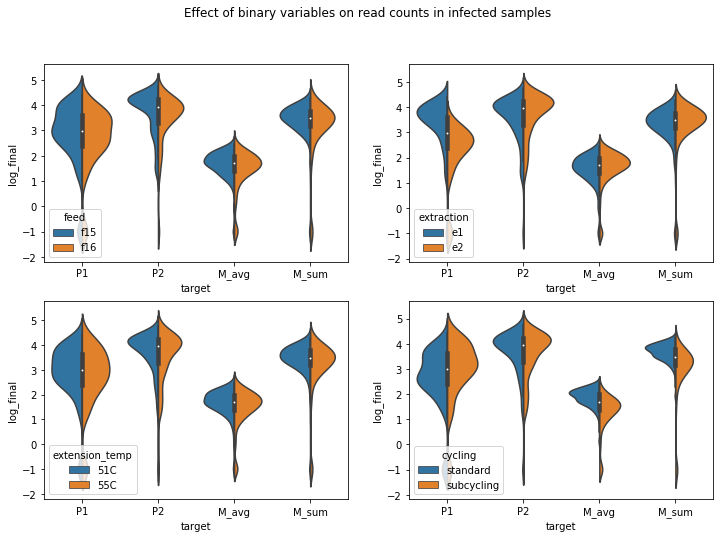

In [16]:
fig, axs = plt.subplots(2,2, figsize=(12, 8))
for ax, col in zip(axs.flatten(), ['feed', 'extraction', 'extension_temp', 'cycling']):
    sns.violinplot(data=reads[reads.day != 'un'], 
                   x="target", y="log_final", hue=col,
                   split=True,
                   ax=ax)
fig.suptitle('Effect of binary variables on read counts in infected samples');
# ax.set_title('Extension temperature on infected samples');

## Plasmodium amplicons balance

In [17]:
# correlation between P1 and P2 read counts
pr = reads.pivot('s_Sample','target', 'input').reset_index()
pr = parse_sequence_names(pr)
pr.sample()

target,s_Sample,M_avg,M_sum,P1,P2,extraction,feed,day,specimen,sampling_point,extension_temp,cycling
376,e2_f15_13d7_51c,147.919355,9171.0,98.0,6799.0,e2,f15,13,f15_13d7,f15_13-14,51C,standard


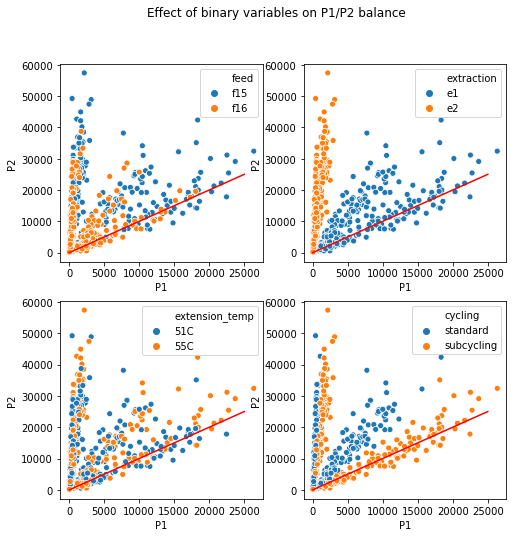

In [18]:
fig, axs = plt.subplots(2,2, figsize=(8, 8))
for ax, col in zip(axs.flatten(), ['feed', 'extraction', 'extension_temp', 'cycling']):
    sns.scatterplot(data = pr,
                x='P1',y='P2',
                hue=col,
                ax=ax);
    ax.plot((0, 25000),(0, 25000), c='r')
fig.suptitle('Effect of binary variables on P1/P2 balance');

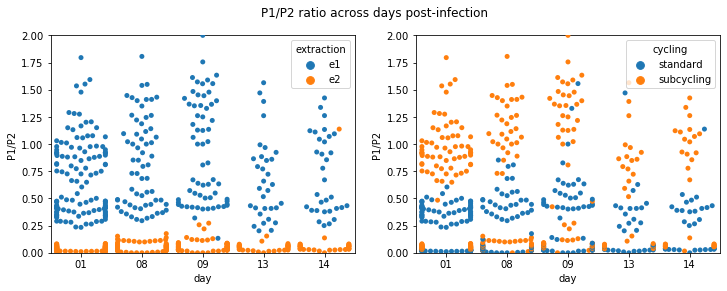

In [19]:
# explicit ratio plotting
pr['P1/P2'] = pr.P1 / pr.P2
d = pr[pr.day != 'un']
fig, axs = plt.subplots(1,2, figsize=(12, 4))
for ax, col in zip(axs.flatten(), ['extraction', 'cycling']):
    sns.swarmplot(data = d,
                x='day',y='P1/P2',
                hue=col,
                ax=ax)
    ax.set_ylim(0, 2);
fig.suptitle('P1/P2 ratio across days post-infection');

## Read filtering 

In [20]:
# parse sample names
reads_init = parse_sequence_names(reads_init)
# group targets
reads_init['tgt_group'] = reads_init.target.str.slice(0,1)
reads_init.loc[~reads_init.target.str.startswith('P'),'tgt_group'] = 'M'
#filter rate
reads_init['filter_rate'] = (reads_init.final / reads_init.input).fillna(-0.1)

reads_init.head(1)

,s_Sample,target,input,filtered,denoisedF,denoisedR,merged,nonchim,final,extraction,feed,day,specimen,sampling_point,extension_temp,cycling,tgt_group,filter_rate
0,e1_blank_51c,0,0,0,0,0,0,0,0,e1,blank,51c,blank_51c,blank_51c,NaN,None,M,-0.1


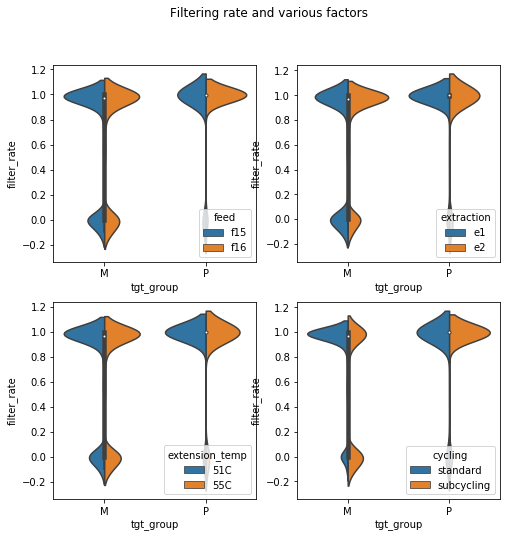

In [21]:
# invidual factor effects
fig, axs = plt.subplots(2,2, figsize=(8, 8))
for ax, col in zip(axs.flatten(), ['feed', 'extraction', 
                                   'extension_temp', 'cycling']):
    sns.violinplot(data=reads_init[reads_init.feed != 'blank'],
                   x='tgt_group',    
                   y='filter_rate',
                   hue=col,
                   split=True,
                   ax=ax)
fig.suptitle('Filtering rate and various factors');
# significantly increased proportion of lost mosquito sequences in subcycling

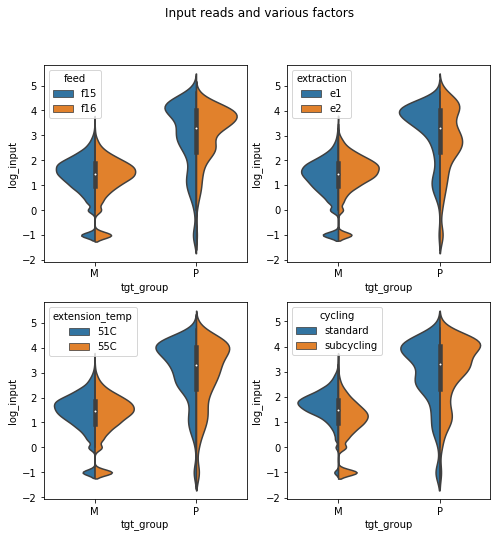

In [22]:
# compare to input reads
reads_init['log_input'] = np.log10(reads_init['input'].replace(0,0.1)).fillna(-1)
#
fig, axs = plt.subplots(2,2, figsize=(8, 8))
for ax, col in zip(axs.flatten(), ['feed', 'extraction', 
                                   'extension_temp', 'cycling']):
    sns.violinplot(data=reads_init[reads_init.feed != 'blank'],
                   x='tgt_group',    
                   y='log_input',
                   hue=col,
                   split=True,
                   ax=ax)
fig.suptitle('Input reads and various factors');

## Same-sample correlations between conditions

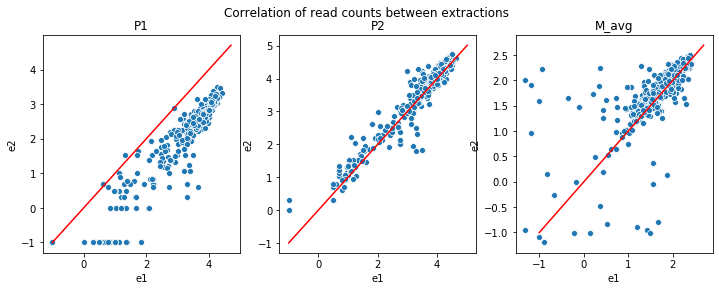

In [23]:
# correlation of read counts for same-specimen between extractions
reads['sample_no_extraction'] = reads.s_Sample.str.slice(start=4)
fig, axs = plt.subplots(1,3, figsize=(12, 4))
for target, ax in zip(['P1', 'P2', 'M_avg'], axs):
    d = reads[reads.target == target] \
            .pivot(columns='extraction',
                   index='sample_no_extraction',
                   values='log_input')
    sns.scatterplot(data=d,
                x='e1',y='e2',
                ax=ax)
    plt_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot((-1, plt_max),(-1, plt_max), c='r')
    ax.set_title(target)
fig.suptitle('Correlation of read counts between extractions');

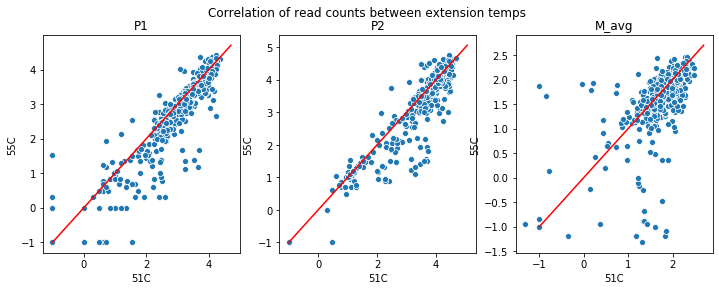

In [24]:
# correlation of read counts for same-specimen between extractions
reads['sample_no_temp'] = reads.s_Sample.str.slice(stop=-4) + reads.s_Sample.str.slice(start=-1)
fig, axs = plt.subplots(1,3, figsize=(12, 4))
for target, ax in zip(['P1', 'P2', 'M_avg'], axs):
    d = reads[reads.target == target] \
            .pivot(columns='extension_temp',
                   index='sample_no_temp',
                   values='log_input')
    sns.scatterplot(data=d,
                x='51C',y='55C',
                ax=ax)
    plt_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot((-1, plt_max),(-1, plt_max), c='r')
    ax.set_title(target)
fig.suptitle('Correlation of read counts between extension temps');

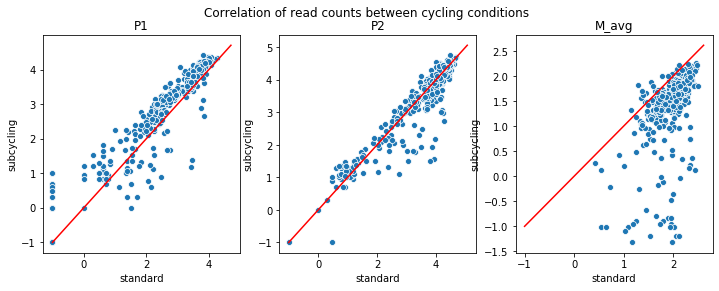

In [25]:
# correlation of read counts for same-specimen between extractions
reads['sample_no_cycling'] = reads.s_Sample.str.slice(stop=-1)
fig, axs = plt.subplots(1,3, figsize=(12, 4))
for target, ax in zip(['P1', 'P2', 'M_avg'], axs):
    d = reads[reads.target == target] \
            .pivot(columns='cycling',
                   index='sample_no_cycling',
                   values='log_input')
    sns.scatterplot(data=d,
                x='standard',y='subcycling',
                ax=ax)
    plt_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot((-1, plt_max),(-1, plt_max), c='r')
    ax.set_title(target)
fig.suptitle('Correlation of read counts between cycling conditions');

## Infection inference

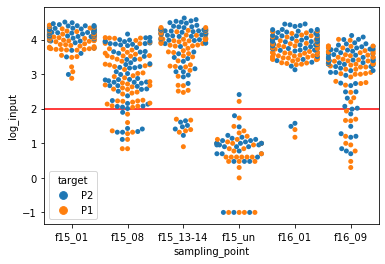

In [26]:
# case 1 - similar yields from both primers, extraction 1 
# set cutoff of 100 reads (can be optimised though)
ds = reads[(reads.extraction == 'e1' )
#           & (reads.cycling == 'subcycling')              /
          & reads.target.str.startswith('P')].sort_values('sampling_point')
sns.swarmplot(data=ds,
              x='sampling_point',
              y='log_input',
              hue='target')
plt.axhline(2, c='r');

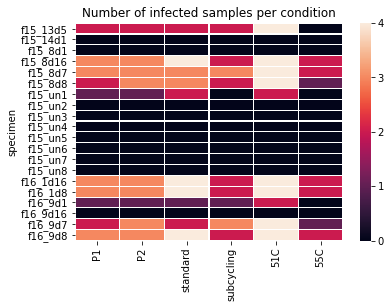

In [27]:
# call 
ds['infected'] = False
ds.loc[ds.log_input >= 2, 'infected'] = True
# infection rates
x = ds.groupby(['specimen','target'])['infected'].sum().unstack()
y = ds.groupby(['specimen','cycling'])['infected'].sum().unstack()
z = ds.groupby(['specimen','extension_temp'])['infected'].sum().unstack()
# specimen at least one uninfected call
dis = pd.concat(
        [x[x.sum(axis=1) < 8],
         y[y.sum(axis=1) < 8],
         z[z.sum(axis=1) < 8]], 
        sort=True,
        axis=1
    ).sort_index()

sns.heatmap(
    dis,
    cbar_kws=dict(ticks=range(5)), 
    linewidths=.1
)
plt.title('Number of infected samples per condition');
# replicates
# 2 primers
# 2 cycling
# 2 extension_temp
# looking at each variable, we observe 4 replicates

Calls are consistent between primers. Heterogeneity occurs due to cycling and annealing. 


Infection rates (minimum if up to half replicates uninfected, maximum if any replicate uninfected):
- feed 15 day 1: 16/16 - 100%
- feed 15 day 8: 12-15/16 - 75-94%
- feed 15 day 13-14: 14/16 - 87.5%
- feed 16 day 1: 14-16/16 - 87.5-100%
- feed 16 day 9: 12-14/16 - 75-87.5%

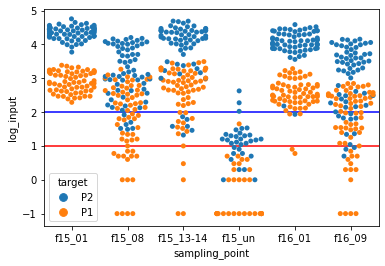

In [28]:
# case 2 - dramatically different yields from primers
# different thresholds for P1 and P2
dd = reads[(reads.extraction == 'e2' )
#           & (reads.cycling == 'subcycling')              /
          & reads.target.str.startswith('P')].sort_values('sampling_point')
sns.swarmplot(data=dd,
              x='sampling_point',
              y='log_input',
              hue='target')
plt.axhline(2, c='b')
plt.axhline(1, c='r');

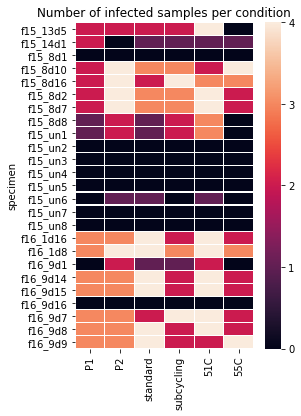

In [29]:
# call 
dd['infected'] = False
dd.loc[(dd.log_input >= 1) & (dd.target == 'P1'), 'infected'] = True
dd.loc[(dd.log_input >= 2) & (dd.target == 'P2'), 'infected'] = True
# infection rates
x = dd.groupby(['specimen','target'])['infected'].sum().unstack()
y = dd.groupby(['specimen','cycling'])['infected'].sum().unstack()
z = dd.groupby(['specimen','extension_temp'])['infected'].sum().unstack()
# specimen at least one uninfected call
did = pd.concat(
        [x[x.sum(axis=1) < 8],
         y[y.sum(axis=1) < 8],
         z[z.sum(axis=1) < 8]], 
        sort=True,
        axis=1
    ).sort_index()

fig, ax = plt.subplots(figsize=(4,6))
sns.heatmap(
    did,
    cbar_kws=dict(ticks=range(5)),
    ax=ax, 
    linewidths=.1
)
plt.title('Number of infected samples per condition');
# replicates
# 2 primers
# 2 cycling
# 2 extension_temp
# looking at each variable, we observe 4 replicates

Heterogeneity between primers - suggest non-optimal thresholds. Playing around does not help much. 


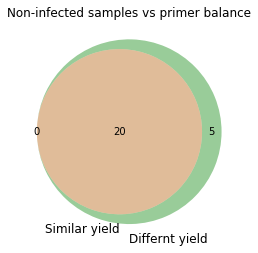

In [30]:
# agreement between methods
from matplotlib_venn import venn2
venn2([set(dis.index), set(did.index)], set_labels = ('Similar yield', 'Differnt yield'))
plt.title('Non-infected samples vs primer balance');

Primer imbalance is bad for infection inference.

In [31]:
raise Exception('analysis ended')

Exception: analysis ended

In [ ]:
## sandbox

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8, 4))
for ax, tgt in zip(axs.flatten(), ['P','M']):
    sns.scatterplot(data = reads[reads.target.str.startswith(tgt)],
                x='log_input',y='log_final',
                hue='target', alpha=0.1,
                ax=ax);
fig.suptitle('Read filtering in Plasmodium and mosquito');